In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from landaupy import langauss
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from tqdm import tqdm
import warnings
from scipy.stats import chisquare

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.simplefilter("error", OptimizeWarning)
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
pedestals=pd.read_csv("pedestals.csv", sep=',')
pedestals=pedestals.drop(columns=['pedestal_per_time_sample', 'std_dev', 'mean'])

In [4]:
mips=pd.read_csv("mip.csv", sep=',')
mips=mips.drop(columns=['eta', 'sigma', 'A'])

In [5]:
def get_event(df, event):
    df=df[df["event"]==event]
    return df

In [6]:
def choose_bar(df,layer, strip):
    df=df[df["strip"]==strip]
    df=df[df["layer"]==layer]
    return df

In [7]:
def choose_layer(df,layer):
    df=df[df['layer']==layer]
    return df

In [8]:
def drop_empty(df):
    data=[]

    layers=np.arange(1,20)
    strips=np.arange(0,12)
    
    for layer in layers:
        for strip in strips:
            el=choose_bar(df,layer,strip)
            peds=choose_bar(pedestals,layer,strip)
            mip=choose_bar(mips, layer, strip)

            if not peds.empty: # need to check whether the strip exists 
                el=el[el["adc_sum_end0"]>1.2*peds.iloc[0,-1]] # gets rid of bars where there's no data in end0
                #el=el[el["adc_sum_end1"]>1.2*peds.iloc[1,-1]] # gets rid of bars where there's no data in end1
                el=el[el["adc_max_end0"]!=1023]
                #el.loc[:,"adc_sum_end0"]-=peds.iloc[0,-1] # subtracting pedestals
                #el.loc[:,"adc_sum_end1"]-=peds.iloc[1,-1]
                
                #el.loc[:,"adc_sum_end0"]*=(4.66/mip.iloc[0,-1]) # converting to energy
                #el.loc[:,"adc_sum_end1"]*=(4.66/mip.iloc[1,-1])
                
                el.loc[:,"adc_sum_end0"]-=peds.iloc[0,-1]
                
                miniped=peds.iloc[0,-1]/8
                el.loc[:,"adc_0_end0"]-=miniped
                el.loc[:,"adc_1_end0"]-=miniped
                el.loc[:,"adc_2_end0"]-=miniped
                el.loc[:,"adc_3_end0"]-=miniped
                el.loc[:,"adc_4_end0"]-=miniped
                el.loc[:,"adc_5_end0"]-=miniped
                el.loc[:,"adc_6_end0"]-=miniped
                el.loc[:,"adc_7_end0"]-=miniped
                
                data.extend(el.values.tolist())
    
    df_s=pd.DataFrame(data, columns=['event', 'adc_sum_end0','adc_max_end0',
                                     'adc_0','adc_1','adc_2','adc_3',
                                     'adc_4','adc_5','adc_6','adc_7',
                                     'layer', 'strip'])
    
    return df_s

In [9]:
def drop_nonelectron(df, bl_num):
    events=df.event.unique()
    
    # check first layer
    for event in tqdm(events):
        el=get_event(df, event)
        el_1=choose_layer(el, 1)
        if el_1.shape[0]>1:
            df=df[df.event!=event]
    
    # check bl_num number of back layers
        else:
            el_i=el[el['layer']>=20-bl_num]
            if el_i.shape[0]:
                df=df[df.event!=event]
            
    return df

In [10]:
def langau(x,A,x_mpv,xi,sigma):
    return A*langauss.pdf(x=x, landau_x_mpv=x_mpv,landau_xi=xi,gauss_sigma=sigma)

In [11]:
def cs(n, y):
    return chisquare(n, np.sum(n)/np.sum(y) * y)

In [12]:
electron=pd.read_csv("run_307_pulse.csv", sep=',')
electron=electron.drop(columns=['tot_end0', 'toa_end0','tot_end1', 'toa_end1', 'adc_max_end1',
                                'pf_spill', 'adc_mean_end0', 'adc_mean_end1', 'pf_ticks','adc_sum_end1',
                               'adc_0_end1','adc_1_end1','adc_2_end1','adc_3_end1',
                               'adc_4_end1','adc_5_end1','adc_6_end1','adc_7_end1'])

electron=electron.astype({"adc_sum_end0":float})#,"adc_sum_end1":float}) 

In [28]:
electron=drop_empty(electron)

In [29]:
electron=drop_nonelectron(electron,7)

100%|███████████████████████████████████████████████████████████████████████████| 35824/35824 [01:44<00:00, 341.85it/s]


In [13]:
big=np.loadtxt("filtered_307.txt")

In [13]:
n=np.shape(big)[0]
n

111979

In [14]:
failed_fit_n=0
data=[]
with warnings.catch_warnings():
    for i in tqdm(range(500)):
        try:
            param,pcov=curve_fit(langau,np.arange(0,80,10),big[i][3:-2], p0=[200,2.0,2,3])
            if param[0]>=5:
                line=[big[i][1]]
                line.extend(param)
                data.append(line)
        except:
            #print(i)
            failed_fit_n+=1
        
param_df=pd.DataFrame(data, columns=['adc_sum','A','landau_x_mpv', 'landau_xi', 'gauss_sigma'])

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [07:05<00:00,  1.17it/s]


In [15]:
param_df.columns

Index(['adc_sum', 'A', 'landau_x_mpv', 'landau_xi', 'gauss_sigma'], dtype='object')

Text(0, 0.5, 'gauss sigma')

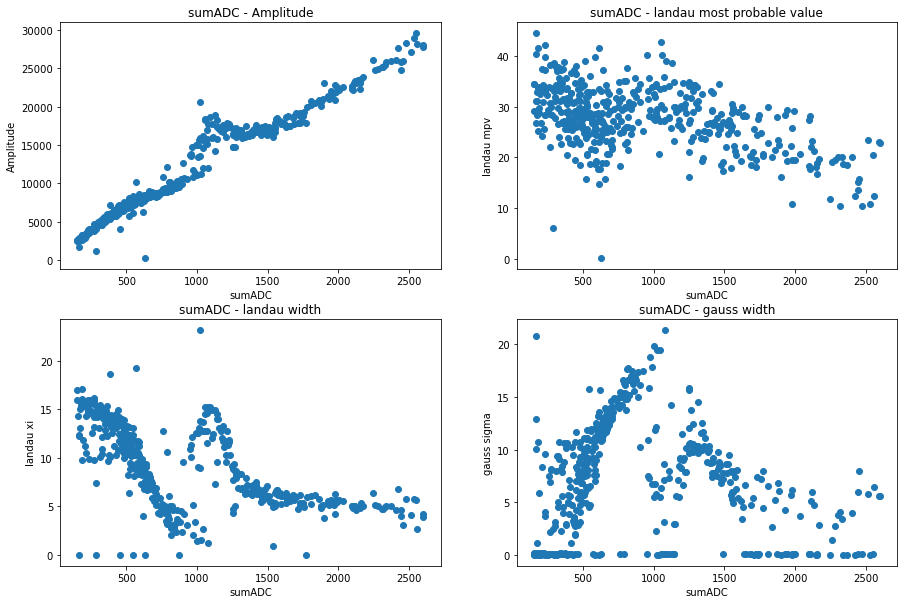

In [16]:
plt.rcParams["figure.figsize"]=(15,10)

plt.subplot(2,2,1)
plt.scatter(param_df['adc_sum'], param_df['A'])
plt.title("sumADC - Amplitude")
plt.xlabel("sumADC")
plt.ylabel("Amplitude")

plt.subplot(2,2,2)
plt.scatter(param_df['adc_sum'], param_df['landau_x_mpv'])
plt.title("sumADC - landau most probable value")
plt.xlabel("sumADC")
plt.ylabel("landau mpv")

plt.subplot(2,2,3)
plt.scatter(param_df['adc_sum'], param_df['landau_xi'])
plt.title("sumADC - landau width")
plt.xlabel("sumADC")
plt.ylabel("landau xi")

plt.subplot(2,2,4)
plt.scatter(param_df['adc_sum'], param_df['gauss_sigma'])
plt.title("sumADC - gauss width")
plt.xlabel("sumADC")
plt.ylabel("gauss sigma")

In [22]:
par_bump=param_df[(param_df['adc_sum']>=1000) & (param_df['adc_sum']<=1500)]

Text(0, 0.5, 'Amplitude')

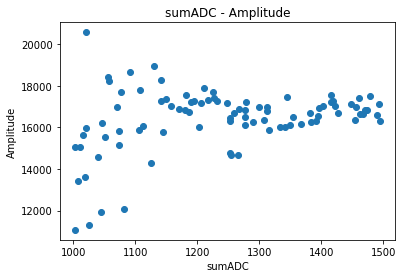

In [23]:
plt.scatter(par_bump['adc_sum'], par_bump['A'])
plt.title("sumADC - Amplitude")
plt.xlabel("sumADC")
plt.ylabel("Amplitude")

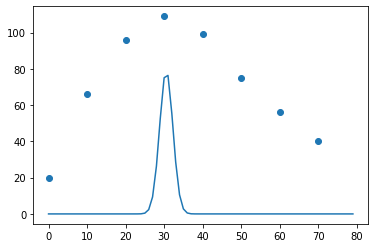

In [55]:
param,pcov=curve_fit(langau,np.arange(0,80,10),big[1002][3:-2], p0=[200,30.0,0.1,3])

plt.rcParams["figure.figsize"]=(6,4)
plt.scatter(np.arange(0,80,10), big[1002][3:-2])
plt.plot(np.arange(0,80), langau(np.arange(0,80), *param))

  3%|██▏                                                                           | 28/1000 [02:44<2:22:46,  8.81s/it]

4.7645712623211706e-120


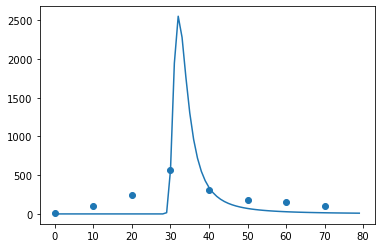

 18%|██████████████▏                                                              | 184/1000 [18:00<1:06:16,  4.87s/it]

6.436425793692973e-39


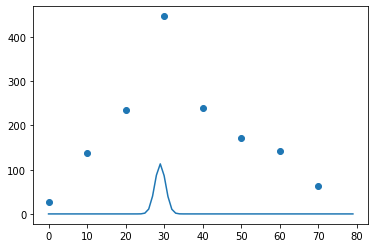

 20%|███████████████▎                                                             | 199/1000 [19:33<1:18:46,  5.90s/it]

2.678200347973458e-164


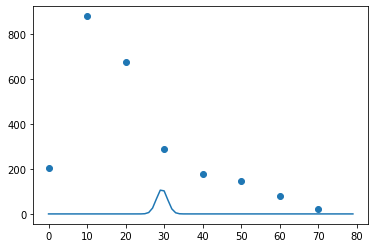

 29%|██████████████████████▌                                                        | 286/1000 [27:37<44:42,  3.76s/it]

5.391098134998305e-40


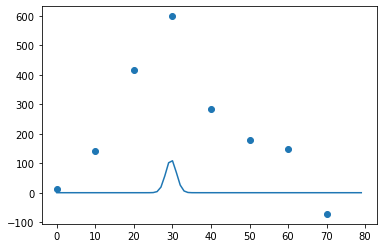

 32%|█████████████████████████                                                      | 317/1000 [30:51<36:33,  3.21s/it]

1.9248464630785118e-28


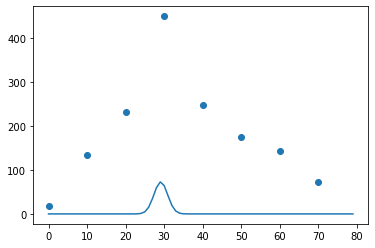

 34%|███████████████████████████                                                    | 343/1000 [34:14<40:51,  3.73s/it]

9.246204752884044e-28


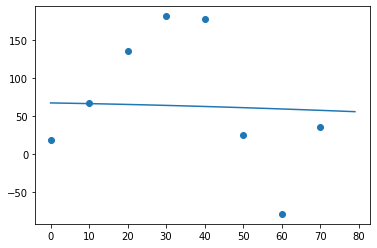

 35%|██████████████████████████▊                                                  | 348/1000 [35:02<1:11:53,  6.62s/it]

2.2304314872880826e-27


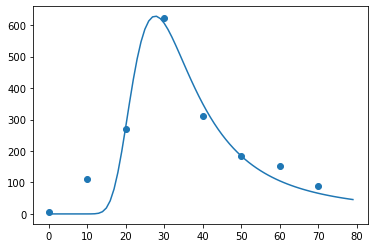

 36%|███████████████████████████▊                                                 | 362/1000 [37:06<1:26:23,  8.13s/it]

2.1917872259351516e-35


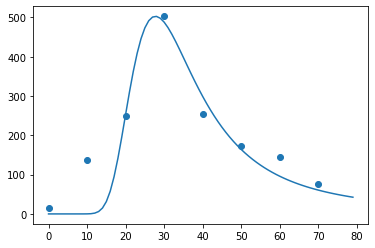

 37%|████████████████████████████▉                                                  | 366/1000 [37:23<57:47,  5.47s/it]

1.1381358276217673e-90


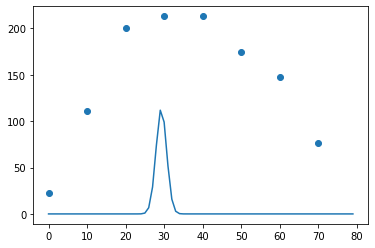

 38%|█████████████████████████████                                                | 378/1000 [38:59<1:17:45,  7.50s/it]

1.5297835291178363e-116


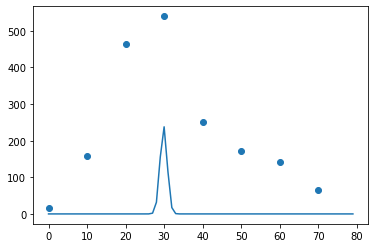

 40%|███████████████████████████████▌                                               | 400/1000 [41:36<57:05,  5.71s/it]

1.6867307930585789e-77


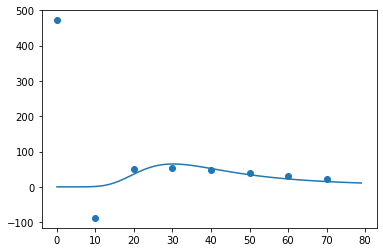

 43%|█████████████████████████████████▉                                             | 430/1000 [44:05<47:33,  5.01s/it]

3.909916152912611e-46


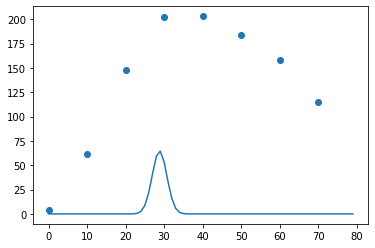

 43%|██████████████████████████████████▏                                            | 432/1000 [44:17<51:06,  5.40s/it]

1.0297963632052916e-43


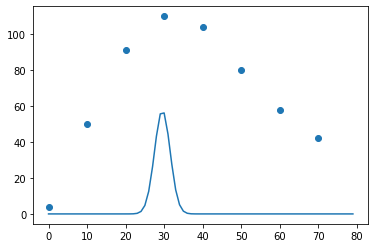

 44%|██████████████████████████████████▎                                            | 435/1000 [44:41<58:14,  6.18s/it]

1.0500609770557222e-214


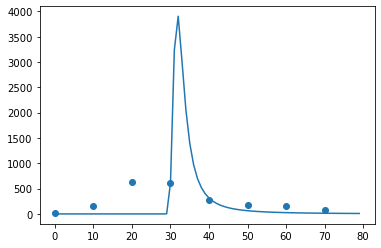

 46%|████████████████████████████████████▎                                          | 460/1000 [46:41<27:52,  3.10s/it]

5.206079831540957e-143


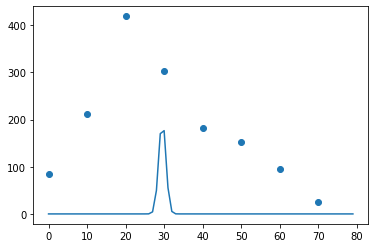

 50%|███████████████████████████████████████▊                                       | 504/1000 [51:12<31:57,  3.87s/it]

1.7562583711822902e-80


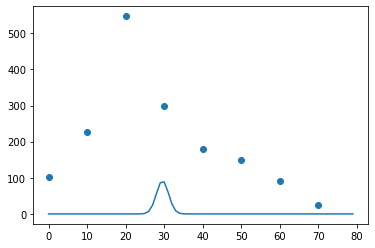

 54%|███████████████████████████████████████▎                                 | 538/1000 [2:39:06<39:40:27, 309.15s/it]

4.0130533616825366e-104


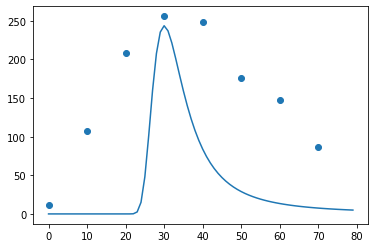

 60%|██████████████████████████████████████████████▎                              | 601/1000 [2:45:18<38:18,  5.76s/it]

1.7159566774161472e-123


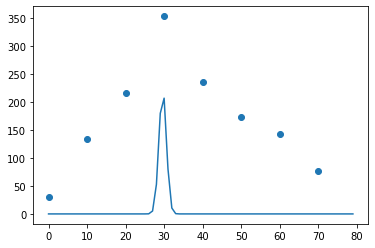

 61%|██████████████████████████████████████████████▉                              | 609/1000 [2:46:03<36:07,  5.54s/it]

4.774158949682467e-47


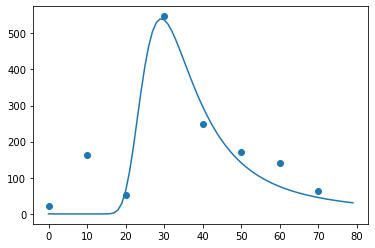

 63%|████████████████████████████████████████████████▏                            | 626/1000 [2:47:21<16:39,  2.67s/it]

In [ ]:
plt.rcParams["figure.figsize"]=(6,4)
pvals=[]
f=0
with warnings.catch_warnings():
    for j in tqdm(range(1000)):
        try:
            param,pcov=curve_fit(langau,np.arange(0,80,10),big[j][3:-2], p0=[200,30.0,0.1,3])
            observed=langau(np.arange(0,80,10), *param)
            expected=big[j][3:-2]
        
            _, pval=cs(observed, expected)
            pvals.append(pval)
            if pval<1e-25 and pval!=0:
                print(pval)
                f+=1
                plt.scatter(np.arange(0,80,10), big[j][3:-2])
                plt.plot(np.arange(0,80), langau(np.arange(0,80), *param))
                plt.show()
        except:
            f+=1

In [ ]:
print("Percentage of bad fits: "+str(round((100*f)/1000))+"%")